In [1]:
%pip install tensorflow keras matplotlib scikit-learn opencv-python tqdm


  Using cached keras-3.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Ensure TensorFlow runs in eager mode
tf.config.run_functions_eagerly(True)


In [4]:
# Define dataset directory
data_dir = "Dataset"  # Change this

# Create necessary folders for saving outputs
os.makedirs("models", exist_ok=True)
os.makedirs("metrics", exist_ok=True)

# Hyperparameters
batch_size = 32
img_size = (224, 224)
seed = 123  # For consistent shuffling

# Load dataset & split it internally (80% Train, 20% Validation)
train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

# Normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset successfully split and preprocessed!")


Found 5680 files belonging to 4 classes.
Using 4544 files for training.


/Users/rafaelzieganpalg/Projects/SRP_Lab/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 5680 files belonging to 4 classes.
Using 1136 files for validation.
Dataset successfully split and preprocessed!


In [20]:
# Load MobileNetV2 with pretrained weights
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = True  # Unfreeze the base model

# Freeze the first 100 layers (to retain useful low-level features)
for layer in base_model.layers[:100]:
    layer.trainable = False
# Add new layers on top for classification
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),  # Reduce overfitting
    layers.Dense(1, activation="sigmoid")  # Binary classification: 'looking' vs 'notlooking'
])

# Compile the model again (lower learning rate)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Smaller LR for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Model summary
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,025,537 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [21]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


In [22]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,   # Reduce LR by 50%
    patience=3,   # If val_accuracy doesn’t improve for 3 epochs
    min_lr=1e-7   # Minimum LR
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  # Train for more epochs
    verbose=1,
    callbacks=[lr_scheduler]
)

# Save trained model
model.save("models/fine_tuned_mobilenetv2.h5")
print("Model saved successfully!")

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5606 - loss: 0.6871 - val_accuracy: 0.5685 - val_loss: 0.6910 - learning_rate: 1.0000e-05
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.6794 - loss: 0.6036 - val_accuracy: 0.5714 - val_loss: 0.6820 - learning_rate: 1.0000e-05
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.7421 - loss: 0.5356 - val_accuracy: 0.5863 - val_loss: 0.6677 - learning_rate: 1.0000e-05
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.7775 - loss: 0.4851 - val_accuracy: 0.6042 - val_loss: 0.6573 - learning_rate: 1.0000e-05
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.7903 - loss: 0.4746 - val_accuracy: 0.6399 - val_loss: 0.6451 - learning_rate: 1.0000e-05
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8098 - loss: 0.4407 - val_accuracy: 0.6429 - val_loss: 0.6280 - learning_rate: 1.0000e-05
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.8383 - loss:

Model saved successfully!


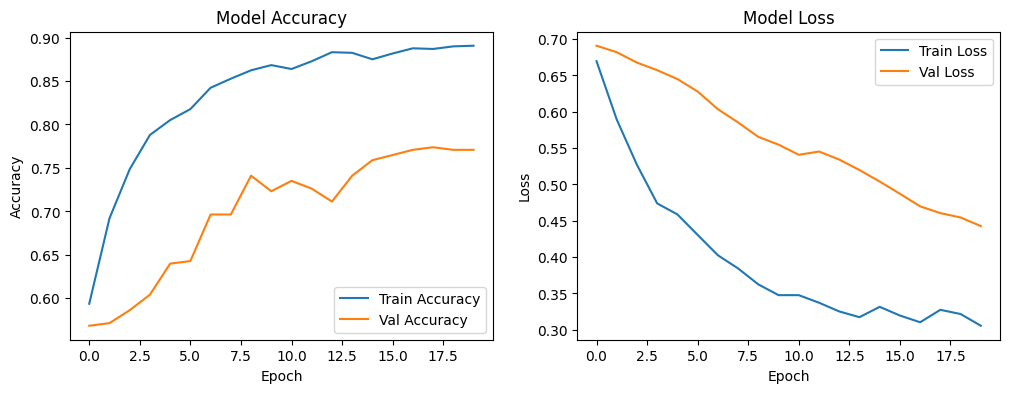

In [23]:
# Plot accuracy & loss curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.savefig("metrics/training_performance.png")
plt.show()


2025-02-19 14:37:32.142959: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 511ms/step


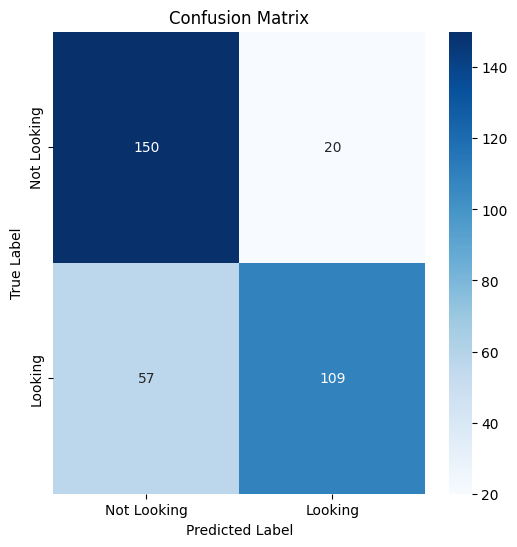

              precision    recall  f1-score   support

 Not Looking       0.72      0.88      0.80       170
     Looking       0.84      0.66      0.74       166

    accuracy                           0.77       336
   macro avg       0.78      0.77      0.77       336
weighted avg       0.78      0.77      0.77       336

Metrics saved successfully!


In [24]:
# Get all validation labels & predictions
y_true = np.concatenate([y.numpy() for _, y in val_dataset], axis=0)
y_pred = model.predict(val_dataset)
y_pred = (y_pred > 0.5).astype(int)  # Convert to 0/1 labels

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Looking", "Looking"], yticklabels=["Not Looking", "Looking"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("metrics/confusion_matrix.png")
plt.show()

# Classification Report (F1-score, precision, recall)
report = classification_report(y_true, y_pred, target_names=["Not Looking", "Looking"])
print(report)

# Save classification report
with open("metrics/classification_report.txt", "w") as f:
    f.write(report)

print("Metrics saved successfully!")


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 536ms/step


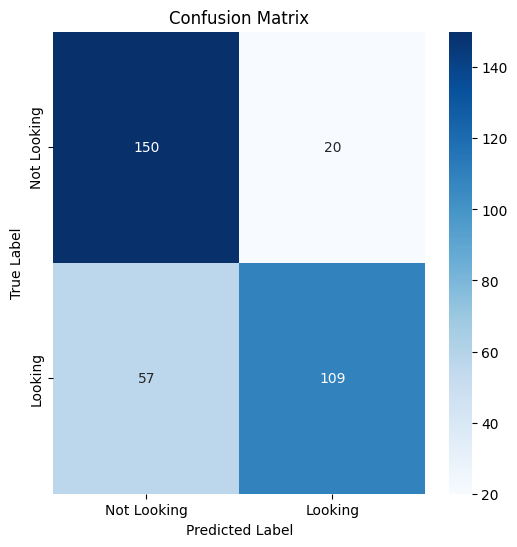

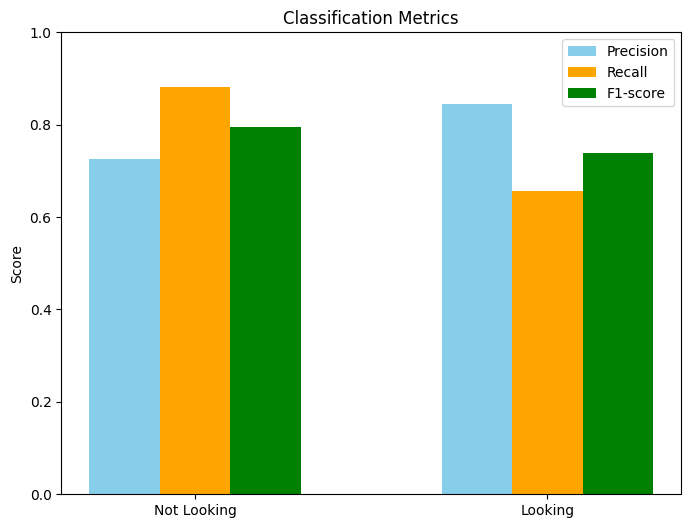

Metrics saved successfully!


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get all validation labels & predictions
y_true = np.concatenate([y.numpy() for _, y in val_dataset], axis=0)
y_pred = model.predict(val_dataset)
y_pred = (y_pred > 0.5).astype(int)  # Convert to 0/1 labels

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Looking", "Looking"], yticklabels=["Not Looking", "Looking"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("metrics/confusion_matrix.png")
plt.show()

# Classification Report (F1-score, precision, recall)
report_dict = classification_report(y_true, y_pred, target_names=["Not Looking", "Looking"], output_dict=True)
report_text = classification_report(y_true, y_pred, target_names=["Not Looking", "Looking"])

# Save classification report
with open("metrics/classification_report.txt", "w") as f:
    f.write(report_text)

# Extract metrics for visualization
categories = ["Not Looking", "Looking"]
precision = [report_dict[cat]["precision"] for cat in categories]
recall = [report_dict[cat]["recall"] for cat in categories]
f1_score = [report_dict[cat]["f1-score"] for cat in categories]

# Plot F1-score, precision, recall
x = np.arange(len(categories))
width = 0.2

plt.figure(figsize=(8, 6))
plt.bar(x - width, precision, width, label="Precision", color="skyblue")
plt.bar(x, recall, width, label="Recall", color="orange")
plt.bar(x + width, f1_score, width, label="F1-score", color="green")

plt.xticks(x, categories)
plt.ylabel("Score")
plt.title("Classification Metrics")
plt.legend()
plt.ylim(0, 1)  # Scores are between 0 and 1
plt.savefig("metrics/classification_metrics.png")
plt.show()

print("Metrics saved successfully!")


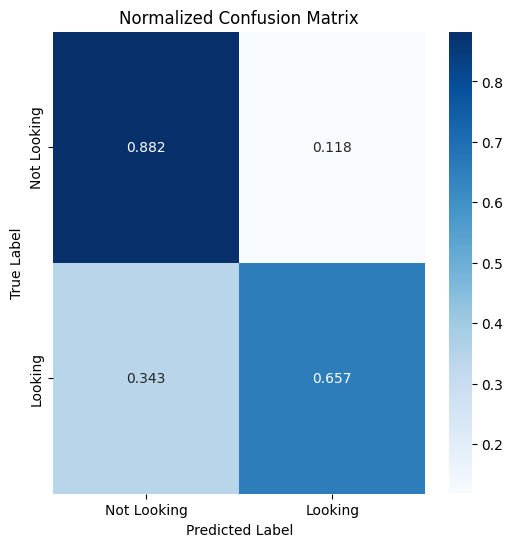

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Given raw confusion matrix
cm = np.array([[150, 20], 
               [57, 109]])

# Normalize row-wise (each row sums to 1)
cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# Plot normalized confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", cmap="Blues", 
            xticklabels=["Not Looking", "Looking"], 
            yticklabels=["Not Looking", "Looking"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.savefig("metrics/normalized_confusion_matrix.png")
plt.show()
